In [1]:
import torch, random, numpy as np
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
print(f"Global seed set to {seed}")

Global seed set to 42


In [2]:
!ls checkpoints/wo_perceptual_sa/


ls: cannot access 'checkpoints/wo_perceptual_sa/': No such file or directory


In [3]:
!wandb login 8285c1e86ba66976957cd9bdbae9e646b37bba8f

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [4]:
# !git clone https://github.com/ayannareda/Weather-Detection-Using-Images.git
# url - /kaggle/working/Weather-Detection-Using-Images/Data

### Dataset Loader

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
import torchvision.transforms as transforms

class ImageFilenameDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.files = []
        for label_name in os.listdir(root):
            label_dir = os.path.join(root, label_name)
            if os.path.isdir(label_dir) and label_name.isdigit():
                for fname in sorted(os.listdir(label_dir))[:2200]:
                    if fname.lower().endswith(('.jpg', '.png')):
                        path = os.path.join(label_dir, fname)
                        self.files.append((path, int(label_name)))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, label = self.files[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

### Model Architecture


In [6]:
# StarGAN Generator with ResNet blocks and Self-Attention
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True))

    def forward(self, x):
        return x + self.main(x)

class Generator(nn.Module):
    """Generator network."""
    def __init__(self, conv_dim=64, n_classes=5, repeat_num=4):
        super(Generator, self).__init__()
        self.n_classes = n_classes
        layers = []
        layers.append(nn.Conv2d(3+self.n_classes, conv_dim, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(repeat_num):
            layers.append(ResidualBlock(dim_in=curr_dim, dim_out=curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.Upsample(scale_factor=2, mode='nearest'))
            layers.append(nn.Conv2d(curr_dim, curr_dim//2, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 3, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        # Replicate spatially and concatenate domain information.
        # Note that this type of label conditioning does not work at all if we use reflection padding in Conv2d.
        # This is because instance normalization ignores the shifting (or bias) effect.
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        return self.main(x)

In [7]:
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm

class Discriminator(nn.Module):
    def __init__(self, image_size=256, conv_dim=64, c_dim=5, repeat_num=6):
        super(Discriminator, self).__init__()
        layers = []

        # Shared convolutional layers (PatchGAN backbone)
        layers.append(spectral_norm(nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1)))
        layers.append(nn.LeakyReLU(0.01, inplace=True))

        curr_dim = conv_dim
        for _ in range(1, repeat_num):
            layers.append(spectral_norm(
                nn.Conv2d(curr_dim, curr_dim * 2,
                          kernel_size=4, stride=2, padding=1)
            ))
            layers.append(nn.LeakyReLU(0.01, inplace=True))
            curr_dim *= 2

        self.shared = nn.Sequential(*layers)

        # PatchGAN adversarial head
        self.conv_adv = spectral_norm(
            nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
        )

        # Global domain classification head
        #  - 1x1 conv to reduce to feature maps, followed by global pooling + linear
        self.conv_cls = spectral_norm(
            nn.Conv2d(curr_dim, curr_dim, kernel_size=3, stride=1, padding=1)
        )
        self.leaky = nn.LeakyReLU(0.01, inplace=True)
        self.interp = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(curr_dim, c_dim, bias=False)

    def forward(self, x):
        h = self.shared(x)          # [B, C, H, W]

        # Adversarial output (PatchGAN style)
        out_src = self.conv_adv(h) # [B, 1, H, W]

        # Classification output (global)
        h_cls = self.conv_cls(h)   # [B, C, H, W]
        h_cls = self.leaky(h_cls)
        h_cls = self.interp(h_cls) # [B, C, 1, 1]
        h_cls = h_cls.view(h_cls.size(0), -1)  # [B, C]
        out_cls = self.fc(h_cls)    # [B, c_dim]

        return out_src, out_cls


In [8]:
from torchvision.models import vgg16

device_ids = list(range(torch.cuda.device_count())) if torch.cuda.is_available() else []

class VGGPerceptualLoss(nn.Module):
    def __init__(self, device, layers=[3,8,15,22]):
        super().__init__()
        self.device = device
        self.selected = set(layers)
        all_layers = list(vgg16(pretrained=True).features)
        # prepare alternating devices
        devices = [torch.device('cuda:0'), torch.device(f'cuda:{device_ids[1]}')] if len(device_ids)>1 else [device, device]
        self.layers = nn.ModuleList()
        for idx, layer in enumerate(all_layers):
            dev = devices[idx % len(devices)]
            layer.to(dev).eval()
            for p in layer.parameters(): p.requires_grad = False
            self.layers.append(layer)
        self.devices = devices

    def forward(self, gen, real):
        xg = (gen + 1) / 2
        xr = (real + 1) / 2
        feats_g, feats_r = [], []
        for idx, layer in enumerate(self.layers):
            dev = self.devices[idx % len(self.devices)]
            xg = layer(xg.to(dev))
            xr = layer(xr.to(dev))
            if idx in self.selected:
                feats_g.append(xg.to(self.device))
                feats_r.append(xr.to(self.device))
        loss = sum(F.l1_loss(g, r) for g, r in zip(feats_g, feats_r))
        return loss

### Training Loop

In [9]:
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import wandb
from torchvision.models import vgg16
from torch.amp import autocast, GradScaler
import os, random
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# define inference transforms and unnormalize
transform_in = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
unnormalize = transforms.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std =[2.0,  2.0,  2.0]
)

def train(G, D, perceptual_loss, train_loader, val_loader, optim_G, optim_D, device,
          epochs=50, lambda_rec=10.0, lambda_perc=0.1, lambda_cls=1.0,
          checkpoint_dir='checkpoints', resume_path=None, dataset=None):
    # initialize metrics storage
    metrics = {
        'train_adv': [], 'train_rec': [], 'train_perc': [], 'train_cls': [],
        'val_adv':   [], 'val_rec':   [], 'val_perc':   [], 'val_cls': []
    }
    os.makedirs(checkpoint_dir, exist_ok=True)

    start_epoch = 1
    # -- resume if provided --
    if resume_path and os.path.exists(resume_path):
        ckpt = torch.load(resume_path, map_location=device)
        G.load_state_dict(ckpt['G_state']); D.load_state_dict(ckpt['D_state'])
        optim_G.load_state_dict(ckpt['optim_G_state']); optim_D.load_state_dict(ckpt['optim_D_state'])
        start_epoch = ckpt.get('epoch', 1) + 1
        print(f"Resuming from epoch {start_epoch}")

    adv_criterion = torch.nn.MSELoss()
    rec_criterion = torch.nn.L1Loss()
    cls_criterion = torch.nn.CrossEntropyLoss()
    G.to(device); D.to(device)
    scaler = GradScaler('cuda')

    for epoch in range(start_epoch, epochs+1):
        G.train(); D.train()
        train_stats = {'adv': [], 'rec': [], 'perc': [], 'cls': []}
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]")
        for real_x, real_lbl in pbar:
            real_x = real_x.to(device)
            B = real_x.size(0)
            idx = torch.randperm(B)
            target_lbl = real_lbl[idx].to(device)
            target_oh = F.one_hot(target_lbl, G.module.n_classes if hasattr(G,'module') else G.n_classes).float().to(device)

            # Discriminator update
            optim_D.zero_grad()
            with autocast('cuda'):
                fake_x = G(real_x, target_oh).detach()
                real_src, real_cls = D(real_x)
                fake_src, _ = D(fake_x)
                loss_D_adv = adv_criterion(real_src, torch.ones_like(real_src)) + \
                             adv_criterion(fake_src, torch.zeros_like(fake_src))
                loss_D_cls = cls_criterion(real_cls, real_lbl.to(device))
                loss_D = loss_D_adv + lambda_cls * loss_D_cls
            scaler.scale(loss_D).backward()
            scaler.step(optim_D)
            scaler.update()

            # Generator update
            optim_G.zero_grad()
            with autocast('cuda'):
                fake_x = G(real_x, target_oh)
                adv_out, cls_out = D(fake_x)
                rec_lbl_oh = F.one_hot(real_lbl.to(device), G.module.n_classes if hasattr(G,'module') else G.n_classes).float().to(device)
                rec_x = G(fake_x, rec_lbl_oh)
                perc_loss = perceptual_loss(fake_x, real_x)
                loss_G_adv = adv_criterion(adv_out, torch.ones_like(adv_out))
                loss_G_cls = cls_criterion(cls_out, target_lbl)
                loss_G = loss_G_adv + \
                         lambda_rec * rec_criterion(rec_x, real_x) + \
                         lambda_perc * perc_loss + \
                         lambda_cls * loss_G_cls
            scaler.scale(loss_G).backward()
            scaler.step(optim_G)
            scaler.update()

            # collect stats
            train_stats['adv'].append(loss_G_adv.item())
            train_stats['rec'].append(rec_criterion(rec_x, real_x).item())
            train_stats['perc'].append(perc_loss.item())
            train_stats['cls'].append(loss_G_cls.item())
            pbar.set_postfix({k: np.mean(v) for k, v in train_stats.items()})

        # Validation
        G.eval(); D.eval()
        val_stats = {'adv': [], 'rec': [], 'perc': [], 'cls': []}
        with torch.no_grad():
            vbar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]")
            for real_x, real_lbl in vbar:
                real_x = real_x.to(device)
                B = real_x.size(0)
                idx = torch.randperm(B)
                target_lbl = real_lbl[idx].to(device)
                target_oh = F.one_hot(target_lbl, G.module.n_classes if hasattr(G,'module') else G.n_classes).float().to(device)
                fake_x = G(real_x, target_oh)
                adv_out, cls_out = D(fake_x)
                rec_lbl_oh = F.one_hot(real_lbl.to(device), G.module.n_classes if hasattr(G,'module') else G.n_classes).float().to(device)
                rec_x = G(fake_x, rec_lbl_oh)
                val_perc = perceptual_loss(fake_x, real_x)
                loss_val_cls = cls_criterion(cls_out, target_lbl)
                val_stats['adv'].append(adv_criterion(adv_out, torch.ones_like(adv_out)).item())
                val_stats['rec'].append(rec_criterion(rec_x, real_x).item())
                val_stats['perc'].append(val_perc.item())
                val_stats['cls'].append(loss_val_cls.item())
                vbar.set_postfix({k: np.mean(v) for k, v in val_stats.items()})

        # wandb logging
        wandb.log({
            'epoch': epoch,
            'train/adv': np.mean(train_stats['adv']),
            'train/rec': np.mean(train_stats['rec']),
            'train/perc': np.mean(train_stats['perc']),
            'train/cls': np.mean(train_stats['cls']),
            'val/adv': np.mean(val_stats['adv']),
            'val/rec': np.mean(val_stats['rec']),
            'val/perc': np.mean(val_stats['perc']),
            'val/cls': np.mean(val_stats['cls'])
        })

        if epoch % 3 == 0:
            G.eval()
            os.makedirs('samples', exist_ok=True)
            # sample 7 random images
            # handle Subset vs full dataset``
            sample_list = random.sample(dataset.files, 7)
            num_labels = G.module.n_classes if hasattr(G, 'module') else G.n_classes
            fig, axes = plt.subplots(len(sample_list), num_labels+1, figsize=(3*(num_labels+1), 3*len(sample_list)))
            for i, (img_path, _) in enumerate(sample_list):
                img_orig = Image.open(img_path).convert('RGB')
                img_resized = img_orig.resize((256,256))
                axes[i, 0].imshow(img_resized); axes[i, 0].axis('off')
                for j in range(num_labels):
                    x = transform_in(img_orig).unsqueeze(0).to(device)
                    lbl = torch.tensor([j], device=device)
                    lbl_onehot = F.one_hot(lbl, num_classes=num_labels).float().to(device)
                    with torch.no_grad():
                        fake = G(x, lbl_onehot)
                    fake = unnormalize(fake.squeeze(0).cpu()).clamp(0,1)
                    axes[i, j+1].imshow(transforms.ToPILImage()(fake)); axes[i, j+1].axis('off')
            os.makedirs(f'samples/{VERSION_NAME}', exist_ok=True)
            fig.savefig(os.path.join(f'samples/{VERSION_NAME}', f'epoch_{epoch}.png'))
            plt.close(fig)
            G.train()

        # Save checkpoint
        if epoch % 5 == 0 or epoch == epochs:
            ckpt_path = os.path.join(checkpoint_dir, f"ckpt_epoch_{epoch}.pt")
            torch.save({
                'epoch': epoch,
                'G_state': G.state_dict(),
                'D_state': D.state_dict(),
                'optim_G_state': optim_G.state_dict(),
                'optim_D_state': optim_D.state_dict()
            }, ckpt_path)
        metrics['train_adv'].append(np.mean(train_stats['adv']))
        metrics['train_rec'].append(np.mean(train_stats['rec']))
        metrics['train_perc'].append(np.mean(train_stats['perc']))
        metrics['train_cls'].append(np.mean(train_stats['cls']))
        metrics['val_adv'].append(np.mean(val_stats['adv']))
        metrics['val_rec'].append(np.mean(val_stats['rec']))
        metrics['val_perc'].append(np.mean(val_stats['perc']))
        metrics['val_cls'].append(np.mean(val_stats['cls']))
    # end epochs
    return metrics

In [10]:
import torch.nn as nn
import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate models
G = Generator().to(device)
D = Discriminator().to(device)
perceptual_loss = VGGPerceptualLoss(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    G = nn.DataParallel(G)
    D = nn.DataParallel(D)

# Optimizers
optim_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Transforms
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Create dataset and split into train and validation sets
BATCH_SIZE = 42
DATASET_PATH = '/kaggle/working/Weather-Detection-Using-Images/Data'
# DATASET_PATH = '/kaggle/input/five-weather-23k'
VERSION_NAME = "perceptual_included"
dataset = ImageFilenameDataset(DATASET_PATH, transform=transform)
train_size = int(1.0 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# lambdas
lambda_cls = 1.0
lambda_rec = 10.0
lambda_perc = 1.0

# Initialize wandb
wandb.init(project='WeatherGAN', name=VERSION_NAME,
    # resume= "allow",
    # id='g0pyuszq',
    config={
    'epochs': 80,
    'batch_size': BATCH_SIZE,
    'lr': 2e-4,
    'lambda_cls': lambda_cls,
    'lambda_rec': lambda_rec,
    'lambda_perc': lambda_perc,
})

# Call train_starGAN function
metrics = train(
    G, D, perceptual_loss,
    train_loader, val_loader,
    optim_G, optim_D,
    device,
    epochs=80,
    lambda_cls=lambda_cls,
    lambda_rec=lambda_rec,  
    lambda_perc=lambda_perc,
    checkpoint_dir=f'checkpoints/{VERSION_NAME}',
    dataset=dataset,
    # resume_path=f"checkpoints/{VERSION_NAME}/ckpt_epoch_5.pt"
)

# No need to save metrics as .pkl, all metrics are logged to wandb

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using 2 GPUs


wandb: Currently logged in as: hrithik-v (hrithik-v-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch 1/80 [Train]: 100%|██████████| 111/111 [05:19<00:00,  2.88s/it, adv=0.401, rec=0.237, perc=1.07, cls=1.59]
Epoch 1/80 [Val]: 0it [00:00, ?it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Epoch 2/80 [Train]: 100%|██████████| 111/111 [05:17<00:00,  2.86s/it, adv=0.344, rec=0.209, perc=0.927, cls=1.55]
Epoch 2/80 [Val]: 0it [00:00, ?it/s]
Epoch 3/80 [Train]: 100%|██████████| 111/111 [05:18<00:00,  2.87s/it, adv=0.332, rec=0.19, perc=0.922, cls=1.21] 
Epoch 3/80 [Val]: 0it [00:00, ?it/s]
Epoch 4/80 [Train]: 100%|██████████| 111/111 [05:18<00:00,  2.87s/it, adv=0.316, rec=0.184, perc=0.899, cls=1.02]
Epoch 4/80 [Val]: 0it [00:00, ?it/s]
Epoch 5/80 [Train]: 100%|██████████| 111/111 [05:17<00:00,  2.86s/it, adv

In [11]:
!ls ./checkpoints/perceptual

ls: cannot access './checkpoints/perceptual': No such file or directory


---

In [12]:
!ls

checkpoints  Five-Weather-23k  samples	wandb  Weather-Detection-Using-Images


## Inference time

/tmp/ipykernel_5711/714028075.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(f'./checkpoints/{VERSION_NAME}/ckpt_epoch_80.pt', map_location=device)


Using 2 GPUs


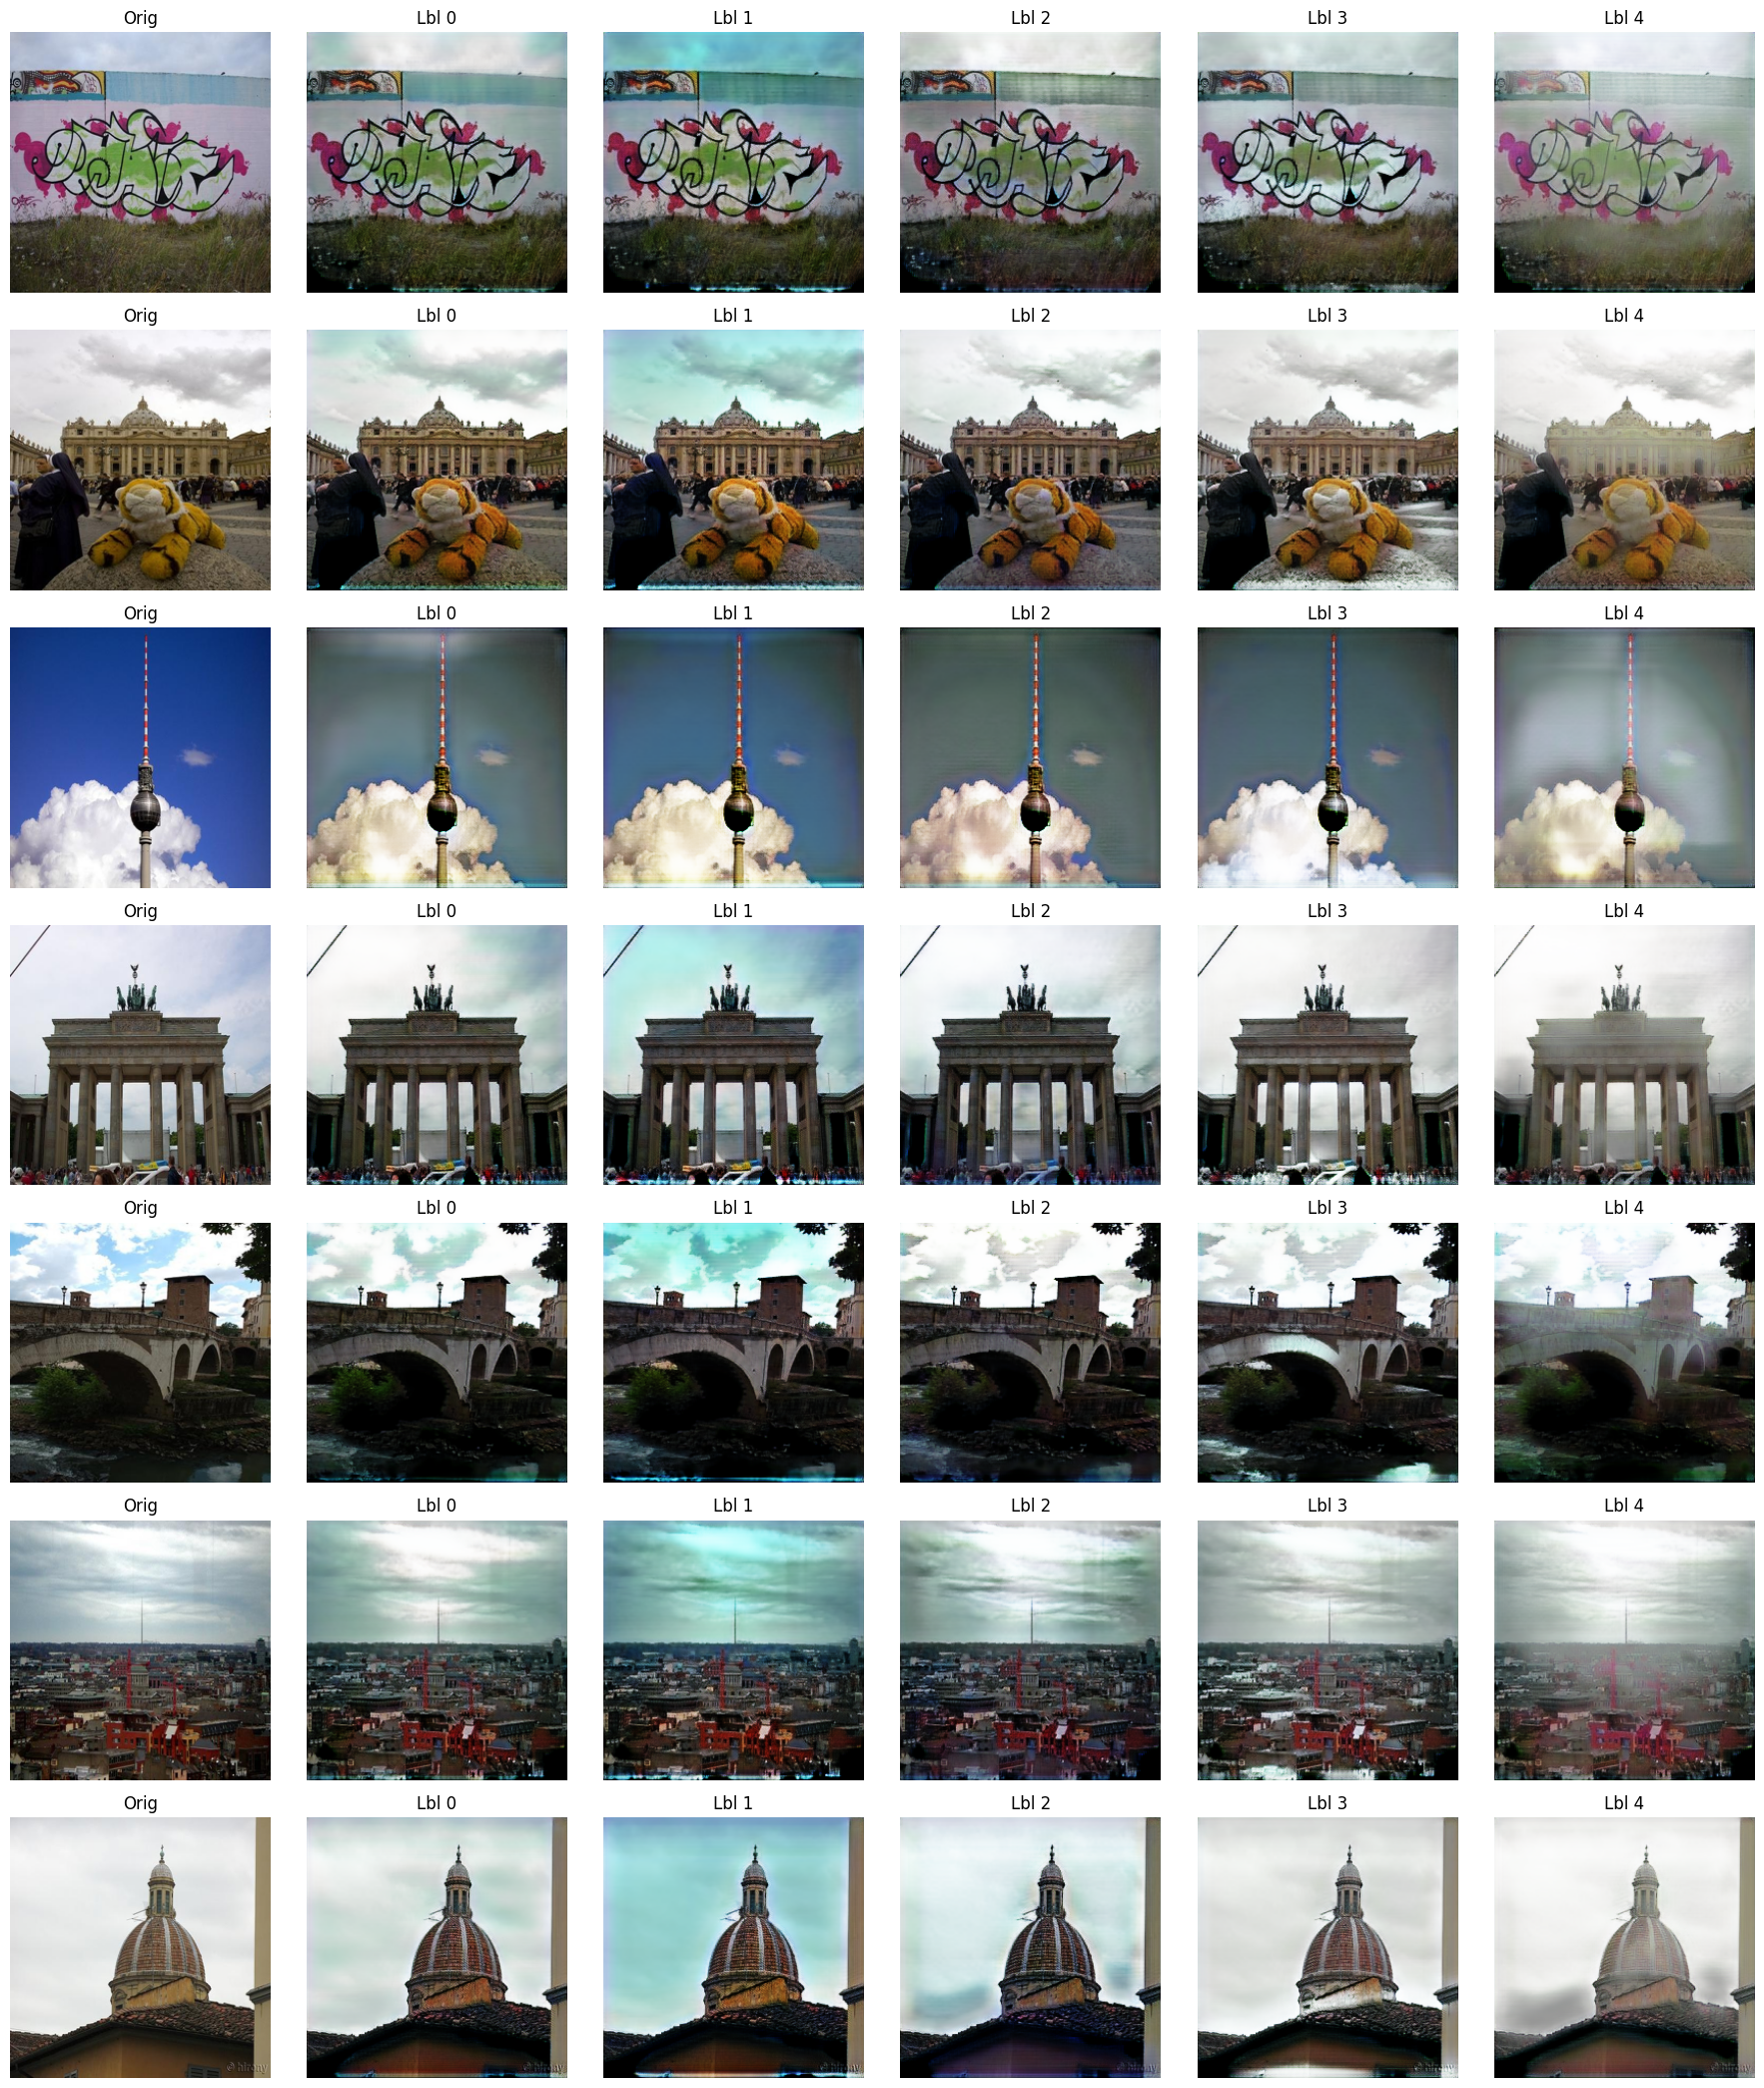

In [14]:
# Inference for 10 images from class '0' and all target labels
import torch
import os
import random
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) define transforms (must match training)
transform_in = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# 2) helper to undo Normalize
unnormalize = transforms.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std =[2.0,  2.0,  2.0]
)

# 3) load checkpoint & build model
ckpt = torch.load(f'./checkpoints/{VERSION_NAME}/ckpt_epoch_80.pt', map_location=device)
# If model was trained with DataParallel, wrap before loading state dict

G = Generator().to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    G = nn.DataParallel(G)
G.load_state_dict(ckpt['G_state'])
G.eval()

# 4) inference function
def infer(img_path, target_label):
    img = Image.open(img_path).convert('RGB')
    x = transform_in(img).unsqueeze(0).to(device)
    lbl = torch.tensor([target_label], device=device)
    # handle DataParallel vs single‐GPU
    num_classes = G.module.n_classes if hasattr(G, 'module') else G.n_classes
    lbl_onehot = F.one_hot(lbl, num_classes=num_classes).float().to(device)
    with torch.no_grad():
        fake = G(x, lbl_onehot)
    # undo normalization & clamp
    fake = unnormalize(fake.squeeze(0).cpu()).clamp(0,1)
    return img, transforms.ToPILImage()(fake)

# Inference for 10 images from class '0' and all target labels
base_path = DATASET_PATH
dir0 = os.path.join(base_path, '0')
files0 = sorted([f for f in os.listdir(dir0) if f.lower().endswith(('.jpg', '.png'))])
files0 = random.sample(files0, min(7, len(files0)))
num_labels = G.module.n_classes if hasattr(G, 'module') else G.n_classes
fig, axes = plt.subplots(len(files0), 1 + num_labels, figsize=(3*(1+num_labels), 3*len(files0)))
for i, fname in enumerate(files0):
    path = os.path.join(dir0, fname)
    img_orig = Image.open(path).convert('RGB')
    img_resized = img_orig.resize((256,256))
    axes[i, 0].imshow(img_resized); axes[i, 0].axis('off'); axes[i, 0].set_title('Orig')
    for lb in range(num_labels):
        _, gen = infer(path, target_label=lb)
        axes[i, lb+1].imshow(gen); axes[i, lb+1].axis('off'); axes[i, lb+1].set_title(f'Lbl {lb}')
plt.tight_layout(); plt.show()